# Pre-Translation Model Step: Definiting Functions to load necessary data and save produced data

The following functions are not part of the machine translation model but are used to load the necessary preprocessed data and Word2Vec results upfront.<br>
For the machine translation model please scroll down. 

In [1]:
from pickle import dump, load
import numpy as np
import os

In [2]:
# Define path for datasets (containing preprocessed datasets)
path_for_datasets = './Preprocessed_datasets'

# Define path for Word2Vec results
path_for_word2vec = './Word2Vec_Results'
if not os.path.exists(path_for_word2vec):
    os.mkdir(path_for_word2vec)

**Functions to load and save datasets**

In [3]:
# Functions to save preprocessed datasets
def save_text(text, path, filename):
    dump(text, open(path + '/' + filename + '.pkl', 'wb'))
    print('Saved: %s' % filename)

In [4]:
# Function to load preprocessed datasets
def load_text(path, filename):
    data = load(open(path + '/' + filename + '.pkl', 'rb'))
    print('Loaded: %s' % filename)
    return data

In [5]:
# Load necessary data
text_en = load_text(path_for_datasets, 'preprocessed_text_en_small')
text_es = load_text(path_for_datasets, 'preprocessed_text_es_small')

index_text_en = load_text(path_for_datasets, 'index_text_en_small')
index_text_es = load_text(path_for_datasets, 'index_text_es_small')

index2word_map_en = load_text(path_for_word2vec, 'index2word_map_en')
index2word_map_es = load_text(path_for_word2vec, 'index2word_map_es')

word2index_map_en = load_text(path_for_word2vec, 'word2index_map_en')
word2index_map_es = load_text(path_for_word2vec, 'word2index_map_es')

Loaded: preprocessed_text_en_small
Loaded: preprocessed_text_es_small
Loaded: index_text_en_small
Loaded: index_text_es_small
Loaded: index2word_map_en
Loaded: index2word_map_es
Loaded: word2index_map_en
Loaded: word2index_map_es


**Functions to load and save Word2Vec results**

In [6]:
# Function to save numpy arrays (e.g. embedding_matrix)
def save_numpy_arrays(array, path, filename):
    np.save(path + '/' + filename, array)
    print('Saved: %s' % filename)

In [7]:
# Define function to load numpy arrays (e.g. embedding_matrix)
def load_numpy_arrays(path, filename):
    array = np.load(path + '/' + filename + '.npy') 
    print('Loaded: %s' % filename)
    return array

In [8]:
final_embeddings_en = load_numpy_arrays(path_for_word2vec, 'embedding_matrix_en')
final_embeddings_es = load_numpy_arrays(path_for_word2vec, 'embedding_matrix_es')

Loaded: embedding_matrix_en
Loaded: embedding_matrix_es


<br><br><br><br>

# Translation Model - Sequence-to-Sequence Model

For my translation model I chose to implement a Encoder-Decoder Sequence-to-Sequence Model with LSMT cells.


## Reason for Sequence-to-Sequence Model 

A sequence to sequence model aims to map a fixed length input with a fixed length output where the input and output may differ in length. In case of Machine Translation this is an important characteristic as different languages may may differ in the number of words needed to express the same thing. E.g. the English sentence "How are you? has a length of 3, its translation in Spanish ("Qué tal?) only consists of two words. This is way a Sequence-to-Sequence Model is often used to adress problems like Machine learning. 


## Structure of a Simple (Encoder-Decoder) Sequence-to-Sequence Model

A simple Sequence-to-Sequence Model consists of three parts: 
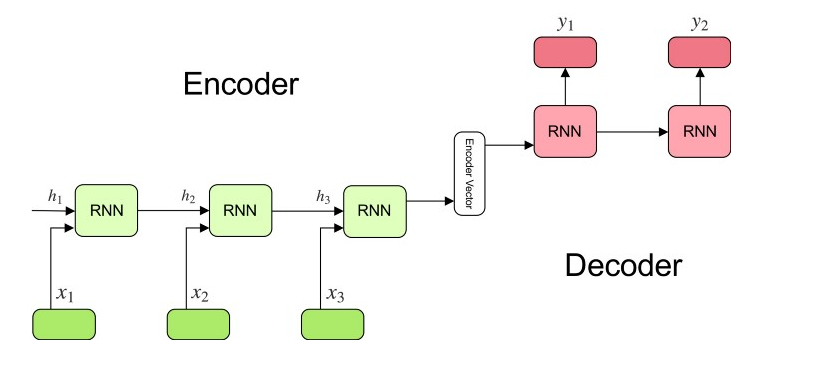
- **Encoder**: Stack of several recurrent units (RNN) accepting the input sequence
- **Encoder vector**: Final hidden state from the encoder which acts as initial hidden state of the decoder
- **Decoder**: Stack of several recurrent units (RNN) predicting the output sequence

The final output of the model is created by means of the **softmax function** which predicts a probability distribution over the next possible tokens. 
This distribution is used for training as well as for prediction. 
- *For training* the probability vector for each word is compared with the true distribution (e.g. probability of 1 on the actual next token). The differences between those distributions are penalized by a loss function, so the models are optimized to minimize the loss. For training my model I used the **cross-entropy** loss which is very common for training such networks.
- *For prediction* the probability vector is analyzed regarding the maximum probability value. The corresponding index is extracted by means of the **argmax-function** and mapped to the as wof the index of the according output word


## Basis of Sequence-to-Sequence Model: Recurrent Neural Networks
<center style="line-height:40px"><i>Recurrent Neural Networks add the immediate past to the present</i></center>
The basis of a Sequence-to-Sequence Model is the Recurrent Neural Networks (RNN). These RNNs are networks that not only take the current input sample as input, but also consider the output of the previous step. This means that the decision of a recurrent network at time step t is affected by the decision it reached at time step t-1. So recurrent networks have two sources of input, the present and the recent past, which combined determine how they respond to new data.
Adding the recent past as input source is done by means of a feedback loop (see image below on the left) which allows information to be passed from one step of the network to the next (see image below on the right) . 

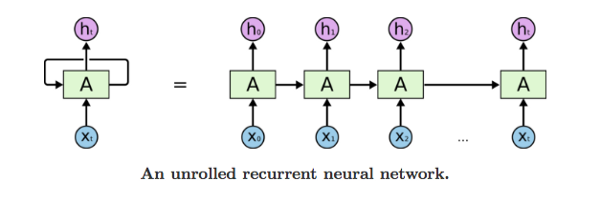

This feedback loop which enables **Backpropagation Through Time** is also the main feature that distinguishes Recurrent Neural Networks from Feedforward networks.
The main advantage of this is, that sequences of data contain crucial information about what is coming next (e.g. in case of the sequence "How are ..." it is very likely that the next token wil be "you"). Unlike feedforward networks, RNNs use this data which allows them to perform task (such as machine translation) that feedforward networks cannot.<br>
While Feed-Forward Neural Networks can only map one input to one output, RNN’s can map one-to-many, many-to-many (used for machine translation) and many-to-one.

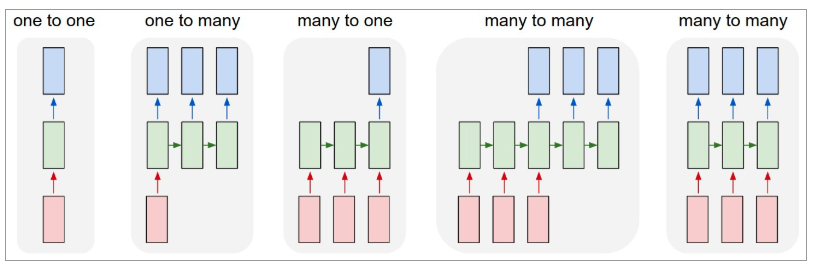

For my translation model I used the forth possibility (many-to-many)


## Enhancements of Simple Sequence-to-Sequence Model
The model described above is a very simple sequence-to-sequence model which cannot be expected to perform very well on complex tasks. Therefore I included the following enhancements:
- **Using Long-Short-Term-Memory (LSTM) cells**: <br>
    Long-Short-Term-Memory cells are an extension for recurrent neural networks, which basically extend their memory and, hence, work slgihtly better in practice. This memory extension is based on a gated cell, which has the ability to contain information outside the normal flow of the recurrent network and enables the RNN to remember their inputs over a long period of time. <br>
    The gated cell acts much like a computer's memory, so information can be stored in, written to or read from it. Via gates that open and close, the memory cell can allow reads and writes as well as decide whether to store or delete information. These decisions are based on the importance of the information - a feature, which is also learned by the celll during the training process. <br>
    As seen in the image below each LSTM cell has three gates:
    - **Input gate**: determining whether or not to let new input in
    - **Forget gate**: determining whether to delete an information (due to low importance)
    - **Output gate**: determining whether to let the new input impact the output of the current time step
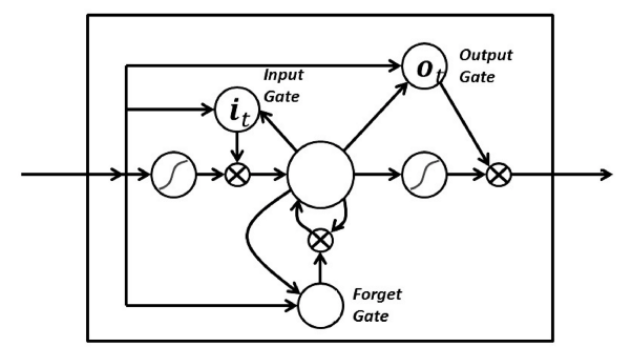
    
- **Reversion the order of the input length**: <br>
    It has been shown (I.Sutskever, O.Vinyals, Q.Le (2014): [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)) that an LSTM learns much better when the source sentences are reversed. The authors see the introduction of many short term dependencies to the dataset as possible reason for that phenomenon. Usually, when concatenating a source sentence with a target sentence, each word in the source sentence is far from its corresponding word in the target sentence. By reversing the words of the source sentence, the mean distance between corresponding words stays the same, the first few words of the source language, however, are very close to the first few words of the target language. "*Thus, backpropagation has an easier time “establishing communication” between the source sentence and the target sentence, which in turn results in substantially improved overall performance*" (I.Sutskever, O.Vinyals, Q.Le (2014): p. 4)

Another important way to improve the model peformance is by using an **attention mechanism**. However, this is not covered in my model.

<br>

### Load necessary imports

In [9]:
import collections
import math
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import glob

### Define some variables

**Define maximum sentence length in the datasets**

In [10]:
# Get max_len of data
def get_max_len(text):
    max_len = 0
    for sentence in text:
        if len(sentence) > max_len:
            max_len = len(sentence)
    return max_len + 2 # for SOS and EOS

In [11]:
max_len_en = get_max_len(text_en)
max_len_es = get_max_len(text_es)
print(max_len_en, max_len_es)

184 210


**Define special symbols**

In [12]:
unk = '<UNK>' # for unknown words (needed for word2vec - see below)
eos = '<EOS>' # to mark the end of a sentence
sos = '<SOS>' # to mark the start of a sentence
pad = '<PAD>' # for padding

## Generate dataset for model and split it into training and testing

**Generate datasets for encoder- and decoder input and for target**

In [13]:
# Padding the dataset and edding EOS, SOS symbols
def generate_data(indexed_text, max_len, word2index_map, incl_sos=False, incl_eos=False, reverse_sent=False): # other option for padding_pos: "pre"
    padded_text = []
    seq_len = []
    for sentence in indexed_text:
        seq_len.append(len(sentence))
        padded_sentence = sentence
        if incl_sos:
            padded_sentence = [word2index_map[sos]] + padded_sentence
        if incl_eos:
            padded_sentence = padded_sentence + [word2index_map[eos]]
        if len(padded_sentence) < max_len:
            pads = [word2index_map[pad]]*(max_len-len(padded_sentence))
            padded_sentence = padded_sentence + pads
        if reverse_sent:
            padded_sentence = padded_sentence[::-1]
        padded_text.append(padded_sentence)
    return padded_text, seq_len

In [14]:
# Create encoder_input_data
encoder_input_data, seq_len_en_data = generate_data(index_text_en, max_len_en, word2index_map_en, incl_sos=False, incl_eos=True, reverse_sent=True)

In [15]:
# Create decoder_input_data, target_data and seq_len_es
decoder_input_data, seq_len_es_data = generate_data(index_text_es, max_len_es, word2index_map_es, incl_sos=True, incl_eos=True, reverse_sent=False)

target_data = []
for sentence in decoder_input_data:
    target_data.append(sentence[1:] + [word2index_map_es[pad]])

In [16]:
#print(index_text_es[1])
#print(decoder_input_data[1])
#print(target_data[1])
print(len(decoder_input_data[1]), len(target_data[1]))
print(np.asarray(encoder_input_data).shape)

210 210
(100000, 184)


**Split the datasets into training and testing**

In [17]:
# Splitting index
last_train_index = int(0.8*len(encoder_input_data))

In [18]:
train_encoder_inputs = encoder_input_data[:last_train_index]
train_decoder_inputs = decoder_input_data[:last_train_index]
train_targets = target_data[:last_train_index]
train_seq_len_en = seq_len_en_data[:last_train_index]
train_seq_len_es = seq_len_es_data[:last_train_index]

In [19]:
test_encoder_inputs = encoder_input_data[last_train_index:]
test_decoder_inputs = decoder_input_data[last_train_index:]
test_targets = target_data[last_train_index:]
test_seq_len_en = seq_len_en_data[last_train_index:]
test_seq_len_es = seq_len_es_data[last_train_index:]

<br>

## Define the Machine Translation Model

### Helper-Functions

**Helper function for batch generation**

In [21]:
def get_sentence_batch(encoder_input_data, decoder_input_data, target_data, seq_len_en_data, seq_len_es_data):
    instance_indices = list(range(len(encoder_input_data)))
    np.random.shuffle(instance_indices)
    batch = instance_indices[:batch_size]
    
    batch_encoder_inputs = [encoder_input_data[i] for i in batch]
    batch_decoder_inputs = [decoder_input_data[i] for i in batch]
    batch_targets = [target_data[i] for i in batch]
    batch_seq_len_en = [seq_len_en_data[i] for i in batch]
    batch_seq_len_es = [seq_len_es_data[i] for i in batch]
    
    return batch_encoder_inputs, batch_decoder_inputs, batch_targets, batch_seq_len_en, batch_seq_len_es

In [22]:
# Test get_sentence_batch()-function
batch_encoder_inputs, batch_decoder_inputs, batch_targets, batch_seq_len_en, batch_seq_len_es = get_sentence_batch(
    encoder_input_data, decoder_input_data, target_data, seq_len_en_data, seq_len_es_data)
#print(batch_encoder_inputs)
print(len(batch_encoder_inputs))
print(np.asarray(batch_encoder_inputs).shape)
print(np.asarray(encoder_input_data).shape)

200
(200, 184)
(100000, 184)


**Helper function to print given test input and output sentence and the model prediction**

In [130]:
# Convert given test data from list of indices to string of corresponding words
def map_index_to_word_sentence(indexed_sentence, seq_len, index2word_map, back_reverse=False):
    # Redo reversing the input sequence (which was done for processing)
    if back_reverse:
        indexed_sentence = indexed_sentence[::-1]
    sentence = []
    for i in range(seq_len):
        # Get word according to index
        word = index2word_map[indexed_sentence[i]]
        sentence.append(word)
    # Join list of words to sentence string
    sentence = ' '.join(sentence)
    return sentence

In [127]:
# Convert probability distribution to sentence of words
def convert_prediction_to_sentence(predictions, index2word_map):
    predicted_sentence = []
    for i in range(len(predictions)):
        prob_vector = predictions[i]
        # Get index of word with highest probability
        predicted_word = index2word_map_es[np.argmax(prob_vector)]
        # Filter out all special symbols that where necessary for processing
        if predicted_word not in [sos, eos, pad]:
            predicted_sentence.append(predicted_word)
    # Join list of words to sentence string
    predicted_sentence = ' '.join(predicted_sentence)
    return predicted_sentence

### Define Hyperparameters and Folderpath for logs

In [ ]:
# Define Hyperparameters
vocabulary_size = 10000
batch_size = 200
num_encoder_layers = 3
num_decoder_layers = 3
num_hidden_units = 128
embedding_size = 32
learning_rate = 0.001
epoch_num = 50
train_batch_num = int(len(train_encoder_inputs)/batch_size)
test_batch_num = 5

In [24]:
# Create folder for logs
save_path_model = './EncoderDecoderModel'
if not os.path.exists(save_path_model):
    os.mkdir(save_path_model)

### Definition and Training of the Machine Translation Model

In [117]:
def encoder_decoder_model():
    
    model_graph = tf.Graph()

    with model_graph.as_default():

        # Input data
        with tf.name_scope('inputs'):
            
            encoder_inputs = tf.placeholder(
                dtype=tf.int32, 
                shape= [batch_size, max_len_en],
                name='encoder_inputs'
            ) 

            decoder_inputs = tf.placeholder(
                dtype=tf.int32, 
                shape= [batch_size, max_len_es], 
                name='decoder_inputs'
            )     

            targets = tf.placeholder(
                dtype=tf.int32,
                shape=[batch_size, max_len_es],
                name='targets'
            ) 

            seq_len_en = tf.placeholder(
                dtype=tf.int32, 
                shape=[None, ], 
                name="seq_len_en"
            )
            seq_len_es = tf.placeholder(
                dtype=tf.int32, 
                shape=[None, ], 
                name="seq_len_es"
            )


        global_step = tf.Variable(0, trainable=False, name='global_step')
        increment_global_step = tf.assign_add(global_step, 1, name = 'increment_global_step')

        # Encoder
        with tf.variable_scope("encoder_word_embeddings"):
            # Include pretrained embeddings for encoder (final_embeddings_en)        
            word_embeddings = tf.get_variable(
                name="word_embedding", 
                shape=[vocabulary_size,embedding_size],
                initializer=tf.constant_initializer(np.array(final_embeddings_en)), 
                trainable=False
            )
            embedded_encoder_inputs = tf.nn.embedding_lookup(word_embeddings, encoder_inputs)

        with tf.variable_scope("encoder"):
            def encoder_lstm_cell():
                encoder_lstm_cell = tf.contrib.rnn.LSTMCell(
                    num_hidden_units, forget_bias=1.0)
                return encoder_lstm_cell
            encoder_cell = tf.contrib.rnn.MultiRNNCell(
                [encoder_lstm_cell() for i in range(num_encoder_layers)], state_is_tuple=True
            )        

            encoder_final_outputs, encoder_final_state = tf.nn.dynamic_rnn(
                cell=encoder_cell, 
                inputs=embedded_encoder_inputs, 
                sequence_length=seq_len_en, 
                dtype=tf.float32
            )


        # Decoder
        with tf.variable_scope('decoder_word_embeddings'):
            # Include pretrained embeddings for decoder (final_embeddings_es)
            word_embeddings = tf.get_variable(
                name="word_embedding", 
                shape=[vocabulary_size,embedding_size],
                initializer=tf.constant_initializer(np.array(final_embeddings_es)), 
                trainable=False
            )
            embedded_decoder_inputs = tf.nn.embedding_lookup(word_embeddings, decoder_inputs)        

        with tf.variable_scope('decoder'):
            def decoder_lstm_cell():
                decoder_lstm_cell = tf.contrib.rnn.LSTMCell(
                    num_hidden_units, forget_bias=1.0)
                return decoder_lstm_cell
            decoder_cell = tf.contrib.rnn.MultiRNNCell(
                [decoder_lstm_cell() for i in range(num_decoder_layers)], state_is_tuple=True
            )

            decoder_final_outputs, decoder_final_state = tf.nn.dynamic_rnn(
                cell=decoder_cell, 
                inputs=embedded_decoder_inputs, 
                sequence_length=seq_len_es, 
                initial_state=encoder_final_state
            )        
            outputs = tf.reshape(decoder_final_outputs, [-1, num_hidden_units])

        weights_softmax = tf.Variable(tf.random_normal([num_hidden_units, vocabulary_size]))
        biases_softmax = tf.Variable(tf.random_normal([vocabulary_size]))

        logits_flat = tf.matmul(outputs, weights_softmax) + biases_softmax
        # Calculate predictions
        prediction = tf.nn.softmax(logits_flat)

        # Calculate loss (cross entropy)
        targets_flat = tf.reshape(targets, [-1])
        losses_flat = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_flat, labels=targets_flat)
        loss = tf.reduce_mean(losses_flat)
        loss_summary = tf.summary.scalar("loss", loss)

        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
        #optimizer = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(loss)
        
        # Calculate accuracy
        correct_prediction = tf.equal(targets_flat, tf.argmax(prediction, axis=1, output_type=tf.int32))   
        accuracy = (tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))*100
        acc_summary = tf.summary.scalar("Accuracy", accuracy)

        merged = tf.summary.merge([acc_summary, loss_summary])

        # Add variable initializer.
        init = tf.global_variables_initializer()

        # Create a saver
        saver = tf.train.Saver(max_to_keep=4, keep_checkpoint_every_n_hours=0.5)
    
    return model_graph, encoder_inputs, decoder_inputs, targets, seq_len_en, seq_len_es, global_step, \
        increment_global_step, prediction, loss, loss_summary, accuracy, acc_summary, init, saver            

In [129]:
def train_model():

    graph, encoder_inputs, decoder_inputs, targets, seq_len_en, seq_len_es, global_step,increment_global_step, \
        prediction, loss, loss_summary, accuracy, acc_summary, init, saver = encoder_decoder_model()

    merged_train = tf.summary.merge([acc_summary, loss_summary])
    merged_test = tf.summary.merge([acc_summary, loss_summary])
        
    with tf.Session(graph=graph) as sess:
        
        # Initialize all variables
        sess.run(init)

        train_writer = tf.summary.FileWriter(os.path.join(save_path_model + "/train"),
                                             graph=tf.get_default_graph())
        test_writer = tf.summary.FileWriter(os.path.join(save_path_model + "/test"),
                                             graph=tf.get_default_graph())

        # Check if there already exists a model for which the training needs to be continued or a new model needs to be trained
        if glob.glob(save_path_model + '/' + '*.meta'):
            imported_meta = tf.train.import_meta_graph(glob.glob(save_path_model + '/' + '*.meta')[0])
            imported_meta.restore(sess, tf.train.latest_checkpoint(save_path_model))
            global_step = sess.run(global_step)
            print("\nRestoring an old model and training it further)
        else:
            sess.run(tf.global_variables_initializer())
            print("Building model from scratch!")

        for epoch in range(epoch_num):

            print("----------- Epoch {0}/{1} -----------".format(epoch, epoch_num))

            average_loss = 0
            average_acc = 0

            ## Train the model
            for batch in range(train_batch_num):       
                
                # Generate batches for training
                batch_encoder_inputs, batch_decoder_inputs, batch_targets, batch_seq_len_en, batch_seq_len_es = \
                    get_sentence_batch(train_encoder_inputs, train_decoder_inputs, train_targets, train_seq_len_en, train_seq_len_es)

                # Train model with generated batches
                input_feed = {
                    encoder_inputs: batch_encoder_inputs,
                    decoder_inputs: batch_decoder_inputs,
                    targets: batch_targets,
                    seq_len_en: batch_seq_len_en,
                    seq_len_es: batch_seq_len_es
                }
                output_feed = [merged_train, loss, accuracy, increment_global_step]
                train_summary, loss_val, acc_val, global_step = sess.run(output_feed, input_feed)

                average_loss += loss_val 
                average_acc += acc_val

                # Add summary
                train_writer.add_summary(train_summary, global_step)
                
                # enter: if batch is vielfaches von 100

            # Print average loss and accuracy of training batches for overlook the training process 
            average_loss /= train_batch_num         
            print('Average loss at batch %d: %5f' % (batch, average_loss))
            average_acc /= train_batch_num        
            print('Average accuracy at batch %d: %5f' % (batch, average_acc))

            # Save the model 
            saver.save(sess, os.path.join(save_path_model, "model"))


            ## Test the model 
            average_accuracy = 0
            for test_batch in range(test_batch_num):
                
                # Generate test batches
                batch_encoder_inputs_test, batch_decoder_inputs_test, batch_targets_test, batch_seq_len_en_test, batch_seq_len_es_test = \
                    get_sentence_batch(test_encoder_inputs, test_decoder_inputs, test_targets, test_seq_len_en, test_seq_len_es)

                # Test model with generates test batches
                input_feed = {
                    encoder_inputs: batch_encoder_inputs,
                    decoder_inputs: batch_decoder_inputs,
                    targets: batch_targets,
                    seq_len_en: batch_seq_len_en,
                    seq_len_es: batch_seq_len_es
                }              
                output_feed = [merged_test, prediction, accuracy]
                test_summary, pred_val, batch_acc = sess.run(output_feed, input_feed)
                
                test_writer.add_summary(test_summary, global_step)
                average_accuracy += batch_acc

            # Print average accuracy for test batches
            average_accuracy /= test_batch_num
            print("Average test accuracy: %.5f" % average_accuracy)
            
            ## Print input sentence and actual and predicted output sentence from last test batch (for comparison)  
            # Extract the first sentence of the last batch
            indexed_input_sentence = batch_encoder_inputs_test[0]
            input_sentence_length = batch_seq_len_en_test[0]
            indexed_output_sentence_act = batch_targets_test[0]
            output_sentence_length = batch_seq_len_es_test[0]
            # Shape of prediction = (batch_size*max_len_es, vocabulary_size) --> single sentence predictions are listed one after the other
            vectorized_output_sentence_pred = pred_val[0:max_len_es][:]
            
            # Convert to sentences 
            input_sentence = map_index_to_word_sentence(indexed_input_sentence, input_sentence_length, index2word_map_en, back_reverse=True)
            output_sentence_act = map_index_to_word_sentence(indexed_output_sentence_act, output_sentence_length, index2word_map_es, back_reverse=False)
            output_sentence_pred = convert_prediction_to_sentence(vectorized_output_sentence_pred, index2word_map_es)
            
            # Print sentence
            print('Input sentence: ' + input_sentence)
            print('Actual output sentence: ' + output_sentence_act)
            print('Predicted output sentence: ' + output_sentence_pred)

    train_writer.close()
    test_writer.close()
    sess.close()

In [128]:
# Train the model 
tf.reset_default_graph()
train_model()

INFO:tensorflow:Restoring parameters from ./EncoderDecoderModel\model

Restoring an old model and training it further --> Starting at step: 1111
----------- Epoch 0/2 -----------
Average loss at batch 100: 8.908488
Average accuracy at batch 100: 0.000000
Mean test accuracy: 0.00000
Input sentence: i-take-it-that-the-council-and-commission-are-not-applying-their-own-standards-of-democratic-rule-of-law-on-a-case-by-case-basis
Actual output sentence: supongo-sin-embargo-que-el-consejo-y-la-comision-no-quieren-mantener-su-propia-norma-sobre-un-estado-democratico-de-derecho-en-cada-caso-aislado
Predicted output sentence: americanas americanas americanas americanas americanas americanas primeras primeras primeras primeras iniciales iniciales iniciales iniciales iniciales iniciales iniciales iniciales iniciales iniciales iniciales iniciales americanas americanas americanas americanas americanas americanas americanas americanas americanas americanas americanas americanas americanas americanas 